# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

### Tecnológico de Monterrey


## **Actividad de la Semana 02**
### **EDA de los conjuntos de datos seleccionados**


Equipo 32

José Adan Vega Pérez [A01796093]

Silvia Xochitl Ibañez Vara [A01795200]

Diego Andrés Bernal Díaz [A01795975]



## Requisitos

In [14]:
import torch

print("Torch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("Versión CUDA:", torch.version.cuda)

assert torch.cuda.is_available(), ("No GPU. Set Runtime → Change runtime type → GPU")

Torch: 2.9.0+cu126
CUDA disponible: True
Versión CUDA: 12.6


In [15]:
import torch

try:
    import torch_geometric
except ModuleNotFoundError:
    torch_version = torch.__version__.split("+")[0]
    cuda_version = torch.version.cuda.replace(".", "")

    !pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv \
        -f https://data.pyg.org/whl/torch-{torch_version}+cu{cuda_version}.html

    !pip install -q torch-geometric


In [16]:
import torch
import torch_geometric

print("Torch:", torch.__version__)
print("Torch Geometric:", torch_geometric.__version__)


Torch: 2.9.0+cu126
Torch Geometric: 2.7.0


In [17]:
from pathlib import Path

# Rutas base
PYG_DIR = Path("./pyg_temp")     # Carpeta temporal para descargas de PyG
FINAL_DATA_DIR = Path("./data")  # Carpeta de datos principal

# Crear carpetas si no existen (idempotente)
for directory in [PYG_DIR, FINAL_DATA_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("Estructura de carpetas verificada:")
print(f"- PYG_DIR: {PYG_DIR.resolve()}")
print(f"- FINAL_DATA_DIR: {FINAL_DATA_DIR.resolve()}")


Estructura de carpetas verificada:
- PYG_DIR: /content/pyg_temp
- FINAL_DATA_DIR: /content/data


## Obtencion de los datasets Wordnet18 y Freebase 15k de pytorch-geometric

In [18]:
import os
import shutil
import pandas as pd
from torch_geometric.datasets import WordNet18RR, FB15k_237

# --- CONFIGURACIÓN ---
PYG_DIR = "./pyg_temp"  # Carpeta temporal para descargas de PyG
FINAL_DATA_DIR = "./data" # Tu carpeta de datos principal

def standard_to_txt(pyg_dataset, dataset_name):
    """
    Toma los archivos raw descargados por PyG y los mueve a tu carpeta ./data
    en formato limpio (head, relation, tail).
    """
    raw_dir = pyg_dataset.raw_dir
    target_dir = os.path.join(FINAL_DATA_DIR, dataset_name)
    os.makedirs(target_dir, exist_ok=True)

    print(f"\nProcesando {dataset_name} desde {raw_dir}...")

    # Mapeo de nombres de archivos de PyG a nombres estándar
    # PyG a veces usa 'train.txt', a veces otros nombres.
    files_map = {
        'train': ['train.txt'],
        'valid': ['valid.txt', 'valid.csv'],
        'test': ['test.txt']
    }

    for split, possible_names in files_map.items():
        found = False
        for fname in possible_names:
            src_path = os.path.join(raw_dir, fname)
            if os.path.exists(src_path):
                found = True
                dst_path = os.path.join(target_dir, f"{split}.txt")

                # Leemos con Pandas para asegurarnos de limpiar headers o índices extra
                try:
                    # FB15k-237 y WN18RR raw suelen venir separados por tabs o espacios
                    df = pd.read_csv(src_path, sep=None, engine='python', header=None, on_bad_lines='skip')

                    # Quedarnos con las primeras 3 columnas (Head, Rel, Tail)
                    # OJO: FB15k-237 a veces viene como (Head, Tail, Rel) o (Head, Rel, Tail)
                    # En los raw files de PyG estándar suele ser: Head, Relation, Tail (Strings)
                    if df.shape[1] >= 3:
                        df = df.iloc[:, :3]

                        # Guardamos en formato limpio separado por comas o tabs
                        df.to_csv(dst_path, sep=',', index=False, header=False)
                        print(f"  -> {split}.txt guardado en {target_dir} ({len(df)} filas)")
                    else:
                        print(f"  [!] Estructura extraña en {fname}: {df.shape}")

                except Exception as e:
                    print(f"  [Error] al procesar {fname}: {e}")
                break

        if not found:
            print(f"  [X] No se encontró archivo para split '{split}'")

# --- 1. DESCARGAR WN18RR ---
print("--- Descargando WordNet18RR usando PyG ---")
# Esto descargará automáticamente los archivos a ./pyg_temp/WordNet18RR/raw
dataset_wn = WordNet18RR(root=os.path.join(PYG_DIR, "WordNet18RR"))
standard_to_txt(dataset_wn, "WN18RR")

# --- 2. DESCARGAR FB15k-237 ---
print("--- Descargando FB15k-237 usando PyG ---")
# Esto descargará automáticamente los archivos a ./pyg_temp/FB15k_237/raw
dataset_fb = FB15k_237(root=os.path.join(PYG_DIR, "FB15k-237"))
standard_to_txt(dataset_fb, "FB15k-237")

print("\n--- ¡LISTO! ---")
print(f"Ahora tienes WN18RR y FB15k-237 en la carpeta '{FINAL_DATA_DIR}' con el mismo formato que el resto.")

--- Descargando WordNet18RR usando PyG ---

Procesando WN18RR desde pyg_temp/WordNet18RR/raw...
  -> train.txt guardado en ./data/WN18RR (86835 filas)
  -> valid.txt guardado en ./data/WN18RR (3034 filas)
  -> test.txt guardado en ./data/WN18RR (3134 filas)
--- Descargando FB15k-237 usando PyG ---

Procesando FB15k-237 desde pyg_temp/FB15k-237/raw...
  -> train.txt guardado en ./data/FB15k-237 (272115 filas)
  -> valid.txt guardado en ./data/FB15k-237 (17535 filas)
  -> test.txt guardado en ./data/FB15k-237 (20466 filas)

--- ¡LISTO! ---
Ahora tienes WN18RR y FB15k-237 en la carpeta './data' con el mismo formato que el resto.


## Obtencion de CoDEx-M, WordNet11, FreeBase13

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests

# Set style for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# --- CONFIGURATION (CORRECTED URLS) ---
DATA_DIR = "./data"

DATASETS = {
    "CoDEx-M": {
        "base_url": "https://raw.githubusercontent.com/tsafavi/codex/master/data/triples/codex-m/",
        "files": ["train.txt", "valid.txt", "test.txt"]
    },
    "WN11": {
        "base_url": "https://raw.githubusercontent.com/KGCompletion/TransL/master/WN11/",
        "files": ["train.txt", "valid.txt", "test.txt"]
    },
    "FB13": {
        "base_url": "https://raw.githubusercontent.com/KGCompletion/TransL/master/FB13/",
        "files": ["train.txt", "valid.txt", "test.txt"]
    }
}


# --- HELPER FUNCTIONS ---
def download_file(url, save_path):
    """Downloads a file from a URL if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {save_path}...")
        try:
            r = requests.get(url)
            r.raise_for_status()
            with open(save_path, 'wb') as f:
                f.write(r.content)
            print(f"  -> Success!")
        except Exception as e:
            print(f"  -> Failed to download {url}: {e}")
    else:
        print(f"Found local: {save_path}")

def load_dataset(name, config):
    """Loads train/valid/test into a dictionary of DataFrames."""
    path = os.path.join(DATA_DIR, name)
    os.makedirs(path, exist_ok=True)

    dfs = {}
    for file_name in config["files"]:
        # 1. Download
        url = config["base_url"] + file_name
        local_path = os.path.join(path, file_name)
        download_file(url, local_path)

        # 2. Load to Pandas
        # Try-catch to handle potential parsing issues
        try:
            # We use engine='python' and sep=None to auto-detect tab or space separators
            # This makes it robust against different format standards
            df = pd.read_csv(local_path, sep=None, engine='python',
                             names=['head', 'relation', 'tail'],
                             on_bad_lines='skip')

            # Clean up: Sometimes the last column has a 4th value (label 1/-1) in older datasets
            # For EDA we usually just want the triplet. Let's check shape.
            if df.shape[1] > 3:
                df = df.iloc[:, :3]
                df.columns = ['head', 'relation', 'tail']

            dfs[file_name.replace('.txt', '')] = df
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    return dfs

# --- EXECUTION ---
print("--- STARTING DATA LOADING ---")
kg_data = {}

for ds_name, config in DATASETS.items():
    print(f"\nProcessing {ds_name}...")
    kg_data[ds_name] = load_dataset(ds_name, config)

    # Quick Sanity Check
    if 'train' in kg_data[ds_name]:
        count = len(kg_data[ds_name]['train'])
        print(f"  -> Loaded {ds_name} Train: {count} triplets")
        print(f"  -> Sample: {kg_data[ds_name]['train'].iloc[0].values}")

print("\n--- READY FOR EDA ---")

--- STARTING DATA LOADING ---

Processing CoDEx-M...
Found local: ./data/CoDEx-M/train.txt
Found local: ./data/CoDEx-M/valid.txt
Found local: ./data/CoDEx-M/test.txt
  -> Loaded CoDEx-M Train: 185584 triplets
  -> Sample: ['Q108946' 'P161' 'Q39792']

Processing WN11...
Found local: ./data/WN11/train.txt
Found local: ./data/WN11/valid.txt
Found local: ./data/WN11/test.txt
  -> Loaded WN11 Train: 112581 triplets
  -> Sample: ['__spiritual_bouquet_1' '_type_of' '__sympathy_card_1']

Processing FB13...
Found local: ./data/FB13/train.txt
Found local: ./data/FB13/valid.txt
Found local: ./data/FB13/test.txt
  -> Loaded FB13 Train: 316232 triplets
  -> Sample: ['antoine_brutus_menier' 'religion' 'roman_catholic_church']

--- READY FOR EDA ---


# 1. Macro-Estadisticas

Before diving deep, you need a high-level comparison table. This establishes the scale.

    Metrics:
        Total Entities
        Total Relations
        Total Triplets
        Split distribution: Count of Train / Validation / Test triples.
        Graph Density: (Is the graph sparse or dense?).
        Average Degree: On average, how many connections does a node have?

    Why it matters: Sparse graphs (like WordNet) are harder for GNNs (Graph Neural Networks) because there is less "message passing."

In [20]:
import os
import pandas as pd
import glob

def calculate_macro_stats(base_dir=FINAL_DATA_DIR):
    stats_list = []

    # Get all subdirectories in ./data
    dataset_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    print(f"Found datasets: {dataset_names}")

    for name in dataset_names:
        ds_path = os.path.join(base_dir, name)

        # Initialize sets to track unique entities and relations across ALL splits
        all_entities = set()
        all_relations = set()

        split_counts = {'train': 0, 'valid': 0, 'test': 0}
        total_triples = 0

        # Process each split
        for split in ['train', 'valid', 'test']:
            file_path = os.path.join(ds_path, f"{split}.txt")

            if os.path.exists(file_path):
                try:
                    # Robust loading: handles comma, tab, or space separators automatically
                    df = pd.read_csv(file_path, sep=None, engine='python', header=None, on_bad_lines='skip')

                    # Ensure we have at least 3 columns
                    if df.shape[1] >= 3:
                        # Extract Head, Relation, Tail (assuming 0=Head, 1=Rel, 2=Tail based on standard formats)
                        # NOTE: Some datasets are H, T, R. Others H, R, T.
                        # For simply COUNTING entities/relations, column order doesn't matter much
                        # as long as we grab the entities and relation columns.
                        # We assume standard H, R, T or H, T, R. We'll take col 1 as relation mostly.
                        # But to be safe for counts, we treat the "middle" as relation usually,
                        # or we can check unique counts to guess, but let's stick to standard H, R, T logic here.

                        heads = df.iloc[:, 0].astype(str)
                        rels = df.iloc[:, 1].astype(str)
                        tails = df.iloc[:, 2].astype(str)

                        # Update counts
                        count = len(df)
                        split_counts[split] = count
                        total_triples += count

                        # Update Unique Sets
                        all_entities.update(heads.unique())
                        all_entities.update(tails.unique())
                        all_relations.update(rels.unique())

                except Exception as e:
                    print(f"Error reading {name}/{split}: {e}")

        # Calculate Derived Metrics
        num_entities = len(all_entities)
        num_relations = len(all_relations)

        # Avoid division by zero
        if num_entities > 0:
            # Avg Degree = Triples / Entities
            avg_degree = total_triples / num_entities

            # Density = Triples / (Entities * (Entities - 1))  [Directed Graph]
            density = total_triples / (num_entities * (num_entities - 1))
        else:
            avg_degree = 0
            density = 0

        stats_list.append({
            'Dataset': name,
            'Entities (|E|)': num_entities,
            'Relations (|R|)': num_relations,
            'Triples (Total)': total_triples,
            'Train': split_counts['train'],
            'Valid': split_counts['valid'],
            'Test': split_counts['test'],
            'Avg Degree': round(avg_degree, 4),
            'Graph Density': density # Keep distinct to see scientific notation if needed
        })

    # Create DataFrame
    df_stats = pd.DataFrame(stats_list)

    # Set Dataset as index
    if not df_stats.empty:
        df_stats = df_stats.set_index('Dataset')

    return df_stats

# --- EXECUTE ---
df_macro_stats = calculate_macro_stats()

# Display formatted table
# We use style to format the Density column because it is usually very small (e.g., 0.0001)
display(df_macro_stats.style.format({
    'Graph Density': '{:.6f}',
    'Avg Degree': '{:.2f}'
}))

Found datasets: ['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


,Entities (|E|),Relations (|R|),Triples (Total),Train,Valid,Test,Avg Degree,Graph Density
Dataset,,,,,,,,
WN18RR,40943,11,93003,86835,3034,3134,2.27,0.000055
FB15k-237,14541,237,310116,272115,17535,20466,21.33,0.001467
FB13,75043,13,375514,316232,11816,47466,5.00,0.000067
CoDEx-M,17050,51,206205,185584,10310,10311,12.09,0.000709
WN11,38588,11,138887,112581,5218,21088,3.60,0.000093


# 2. Análisis de relaciones

Knowledge Graphs rarely have balanced relations. Some relations are incredibly common (e.g., gender), others are rare.

    Analysis:

        Frequency Histogram: Plot the count of triplets per relation.

        Head vs. Tail Relations: Identify which relations make up the top 50% of the data.

    Relevance to Project: If you are extrapolating, it is easier to predict a common relation for a new node than a rare one. If CoDEx-M is more balanced than FB13, your model might perform more consistently there.

# 3. Node Degree Distribution (The "Hubs" Analysis)

This is crucial for graph embeddings. Real-world graphs follow a Power Law (Long Tail).

    Analysis:

        Plot the distribution of node degrees (log-log scale).

        Identify "Hubs" (super-connected nodes, like "USA" in Freebase) vs. "Tail Entities" (nodes with 1 or 2 connections).

    Relevance to Extrapolation (CRITICAL):

        Hypothesis: New entities (unseen) that connect to Hubs are easier to embed because the Hub has a stable, rich representation. New entities that connect only to other sparse nodes are extremely hard to predict.

        Action: Check what percentage of entities in WN11/FB13 have a degree <3

# 4. Connectivity Patterns (The "Structure" Analysis)

Since WN11 comes from WordNet (hierarchy) and FB13 from Freebase (facts), their shapes are different.

    Analysis:

        Clustering Coefficient: Do neighbors of a node know each other? (Triangles).

        Diameter / Average Path Length: How many hops to get from node A to node B?

    Relevance:

        WN11: Likely has low clustering (tree structure, hierarchies don't form many triangles).

        FB13/CoDEx: Likely higher clustering (social networks, movies). GNNs behave differently on trees vs. clustered graphs.

# 5. The "Inductive Bias" Analysis (The Most Important for You)

Since your project is about unseen entities, you must analyze the "gap" between Train and Test. Standard EDAs don't do this, but you must.

A. Unseen Entity Ratio (if using standard splits):

    In the Test set, how many entities are strictly new?

    (Note: If you use the specific benchmarks from Hamaguchi et al. or GraIL, this is 100%, but you should verify it).

B. "Connectivity to Known" Ratio:

    For the triples in the Test set (involving new entities), who are they connected to?

        Scenario A: New Entity

        Old Entity (Seen in Train).

        Scenario B: New Entity


        New Entity.

    Why it matters:

        Scenario A is "Transductive-Inductive". Easier. The model uses the Old Entity as an anchor.

        Scenario B is "Fully Inductive". Extremely hard. If a new node only connects to another new node, the model is "blind."

    The Chart: A bar chart showing the % of test triples that connect to Seen vs. Unseen nodes.

# 6. Text/Semantics Analysis (Optional but recommended)

Since you mentioned using "descriptions" or "external info" for extrapolation.

    Analysis: Calculate the average length of text descriptions for entities in CoDEx vs FB13.

    Relevance: If FB13 has rich text and WN11 has short definitions, your text-based extrapolation model might work better on FB13.

# Estructura de los datos

Found datasets: ['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


| Dataset   | Entities (&#124;E&#124;) | Relations (&#124;R&#124;) | Triples (Total) | Train   | Valid | Test   | Avg Degree | Graph Density |
|-----------|--------------------------|---------------------------|-----------------|---------|-------|--------|------------|---------------|
| WN18RR    | 40,943                   | 11                        | 93,003          | 86,835  | 3,034 | 3,134  | 2.27       | 0.000055      |
| FB15k-237 | 14,541                   | 237                       | 310,116         | 272,115 | 17,535| 20,466 | 21.33      | 0.001467      |
| FB13      | 75,043                   | 13                        | 375,514         | 316,232 | 11,816| 47,466 | 5.00       | 0.000067      |
| CoDEx-M   | 17,050                   | 51                        | 206,205         | 185,584 | 10,310| 10,311 | 12.09      | 0.000709      |
| WN11      | 38,588                   | 11                        | 138,887         | 112,581 | 5,218 | 21,088 | 3.60       | 0.000093      |


1. Descripción del dataset
   - entidades
   - relaciones
   - tripletas
   - cardinalidad por split
   - tipo de dato (categórico, simbólico)

2. Estadísticas estructurales
   - grado promedio
   - densidad
   - tripletas por entidad
   - tripletas por relación

3. Frecuencias de relaciones
   - tabla
   - top 10 + cola larga

4. Valores faltantes
   - NO aplica: En los grafos de conocimiento no existen valores faltantes en el sentido tabular clásico, ya que cada registro corresponde a una relación completa entre dos entidades. La “información incompleta” se manifiesta únicamente de forma estructural mediante nodos con baja conectividad, lo cual se analiza posteriormente en la sección de conectividad del grafo


# Análisis univariante

Dado que los datos corresponden a grafos de conocimiento representados mediante tripletas
(
ℎ
,
𝑟
,
𝑡
)
(h,r,t), las variables originales son categóricas y no contienen atributos numéricos continuos. Por ello, el análisis univariante se realiza sobre métricas estructurales derivadas del grafo, en lugar de sobre los identificadores de entidades o relaciones.

En esta etapa se analizan la distribución del grado de las entidades, la frecuencia de aparición de entidades en las tripletas y la frecuencia de los distintos tipos de relación. Asimismo, se identifican las entidades con mayor grado (hubs), ya que concentran una parte significativa de las conexiones del grafo y pueden influir en el comportamiento de los modelos de aprendizaje. Las visualizaciones empleadas consisten en histogramas y gráficos de barras, adecuados para métricas discretas y distribuciones con cola larga. No se utilizan boxplots, ya que no existen variables numéricas continuas y este tipo de representación no aporta información relevante en este contexto

Boxplots no aplican (no hay datos continuos):

Dado que las variables del grafo son categóricas y no contienen atributos numéricos continuos, no se emplean boxplots. En su lugar, se utilizan histogramas y gráficos de barras sobre métricas estructurales (grado, frecuencia de relaciones), que son las representaciones adecuadas para este tipo de datos


In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def univariate_eda_kg(dataset_dir, dataset_name, top_n=10):
    """
    Performs univariate EDA for a knowledge graph dataset.
    Assumes train.txt, valid.txt, test.txt with (h, r, t).
    """

    all_triples = []

    # Load all splits
    for split in ["train", "valid", "test"]:
        path = os.path.join(dataset_dir, dataset_name, f"{split}.txt")
        if os.path.exists(path):
            df = pd.read_csv(
                path,
                sep=None,
                engine="python",
                header=None,
                on_bad_lines="skip"
            )
            if df.shape[1] >= 3:
                all_triples.append(df.iloc[:, :3])

    if not all_triples:
        print(f"No data found for {dataset_name}")
        return

    df = pd.concat(all_triples, ignore_index=True)
    df.columns = ["head", "relation", "tail"]

    # --- Metric 1: Entity degree (in + out) ---
    degree_counter = Counter(df["head"]) + Counter(df["tail"])
    degrees = list(degree_counter.values())

    # --- Metric 2: Triples per entity ---
    triples_per_entity = degrees  # same count interpretation here

    # --- Metric 3: Relation frequencies ---
    relation_freq = Counter(df["relation"])

    # --- Metric 4: Top-N hubs ---
    top_hubs = degree_counter.most_common(top_n)

    # ================== PLOTS ==================

    plt.figure(figsize=(6, 4))
    plt.hist(degrees, bins=50)
    plt.title(f"{dataset_name} – Distribución del grado de entidades")
    plt.xlabel("Grado")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(triples_per_entity, bins=50)
    plt.title(f"{dataset_name} – Distribución de tripletas por entidad")
    plt.xlabel("Número de tripletas")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    rel_df = pd.DataFrame(
        relation_freq.most_common(top_n),
        columns=["Relación", "Frecuencia"]
    )

    plt.figure(figsize=(7, 4))
    plt.bar(rel_df["Relación"], rel_df["Frecuencia"])
    plt.title(f"{dataset_name} – Frecuencia de relaciones (Top-{top_n})")
    plt.xlabel("Relación")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    hubs_df = pd.DataFrame(top_hubs, columns=["Entidad", "Grado"])

    plt.figure(figsize=(7, 4))
    plt.bar(hubs_df["Entidad"], hubs_df["Grado"])
    plt.title(f"{dataset_name} – Top-{top_n} entidades con mayor grado")
    plt.xlabel("Entidad")
    plt.ylabel("Grado")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


dataset_names = [d for d in os.listdir(FINAL_DATA_DIR) if os.path.isdir(os.path.join(FINAL_DATA_DIR, d))]
print("Datasets:")
print(dataset_names)


Datasets:
['WN18RR', 'FB15k-237', 'FB13', 'CoDEx-M', 'WN11']


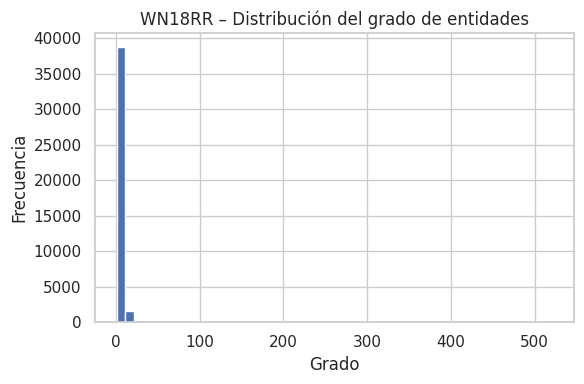

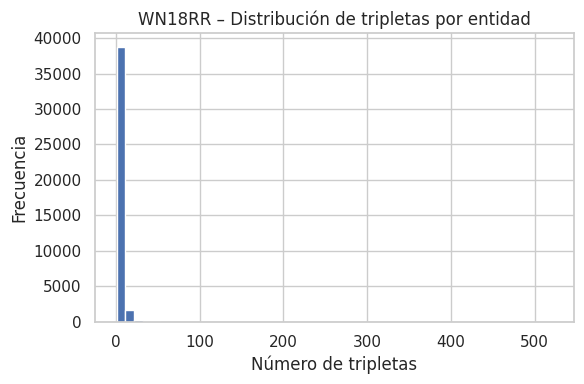

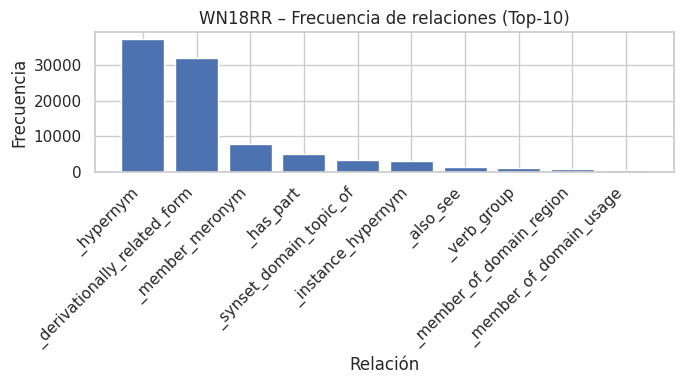

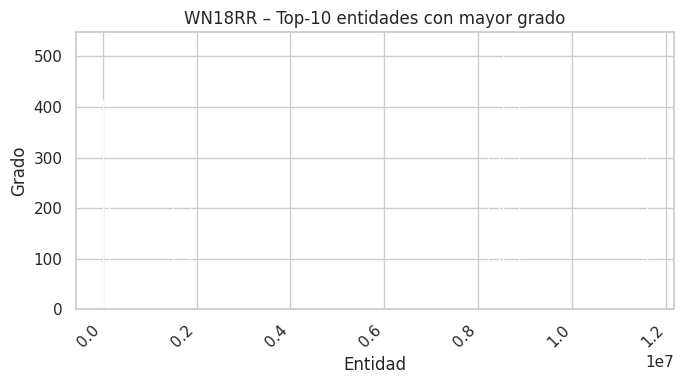

In [22]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="WN18RR", top_n=10)

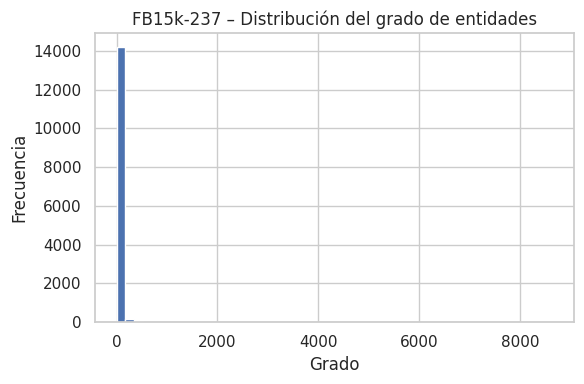

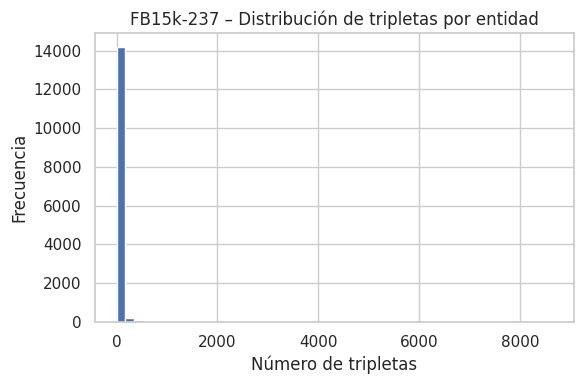

/tmp/ipython-input-2563459766.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


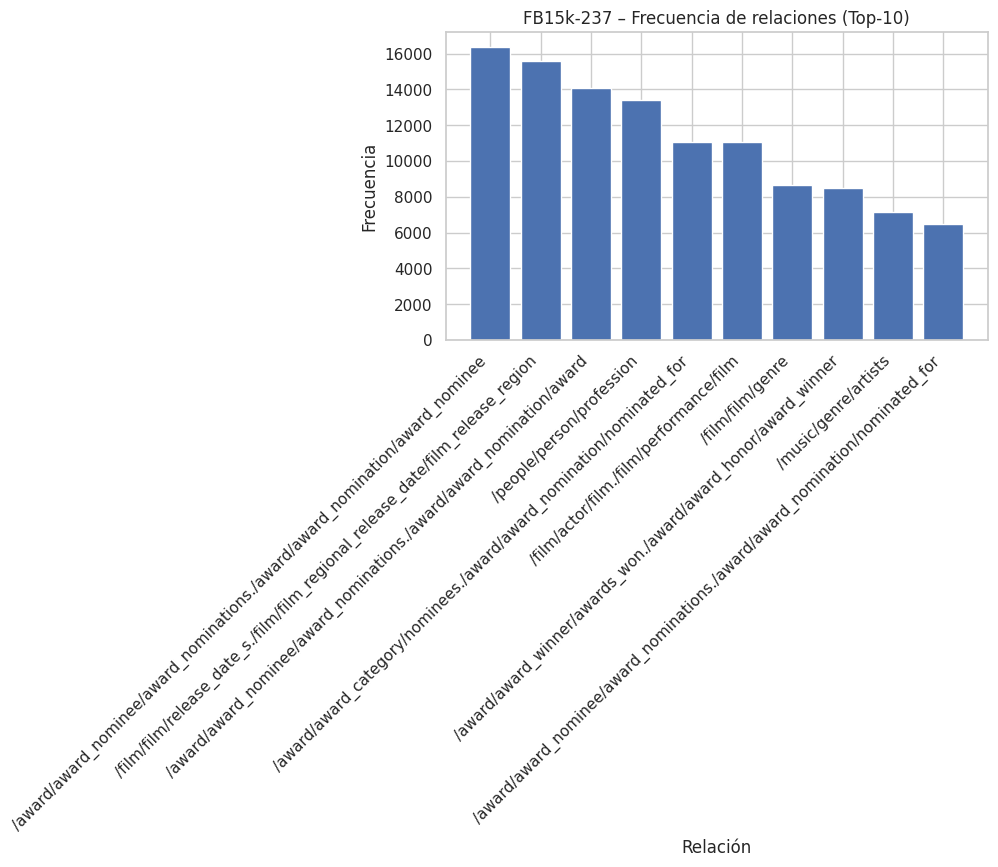

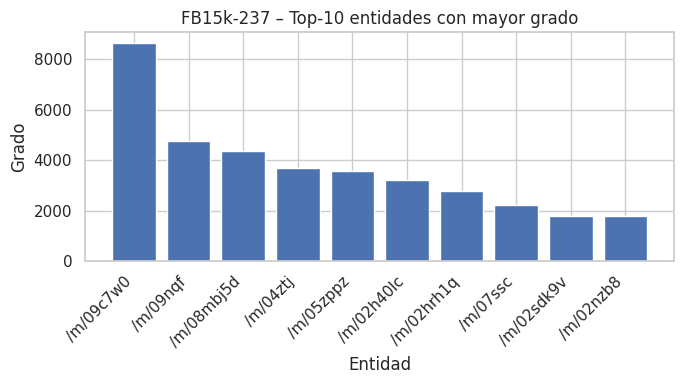

In [23]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="FB15k-237", top_n=10)

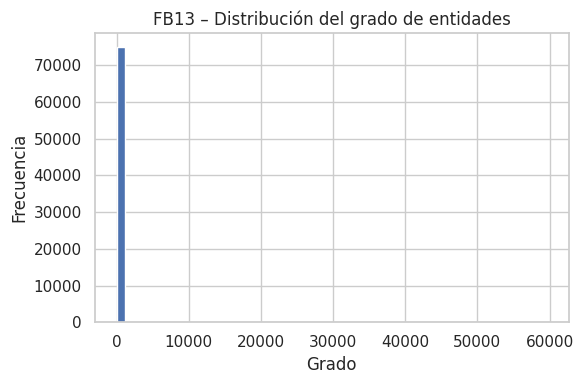

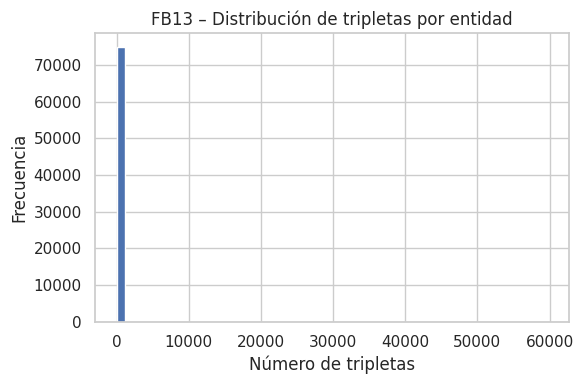

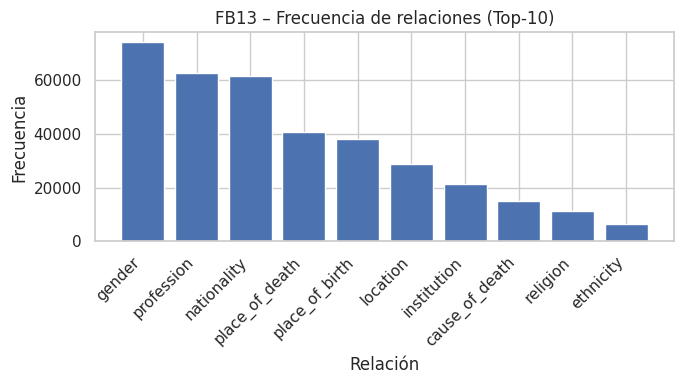

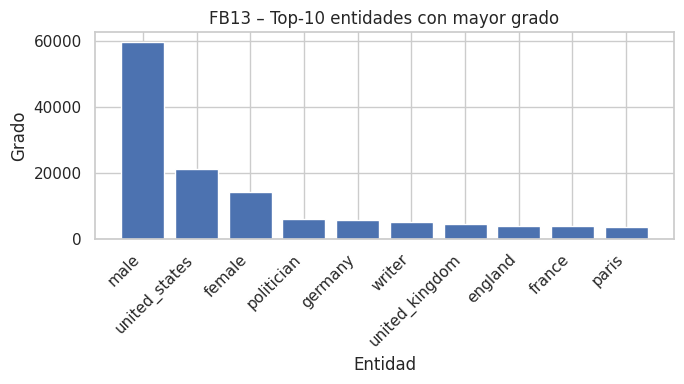

In [24]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="FB13", top_n=10)

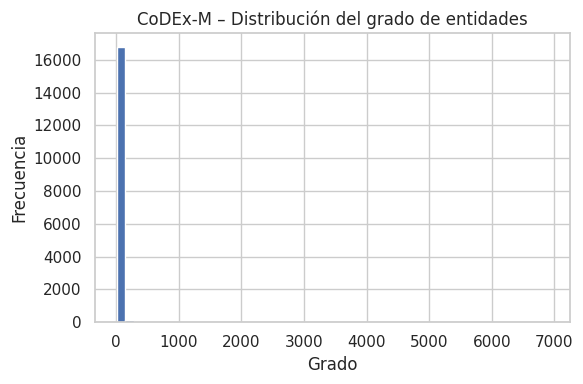

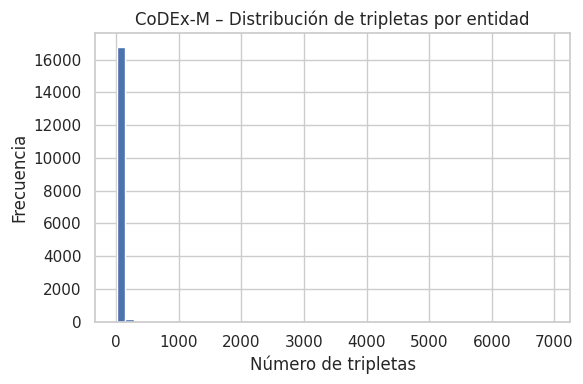

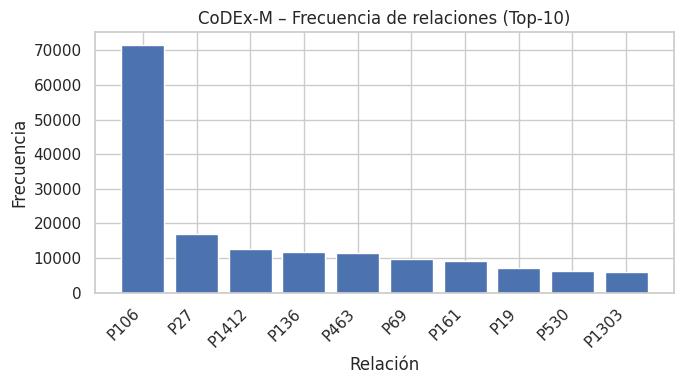

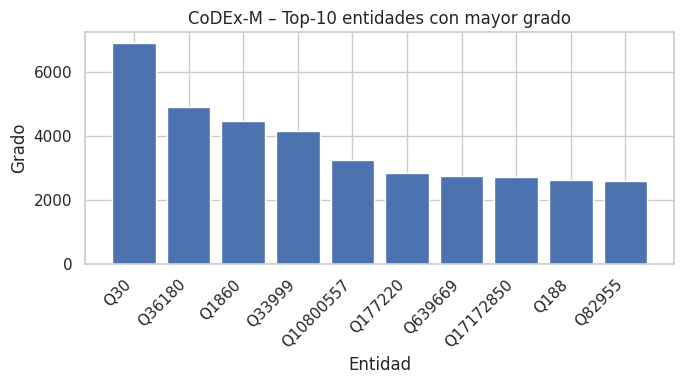

In [25]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="CoDEx-M", top_n=10)

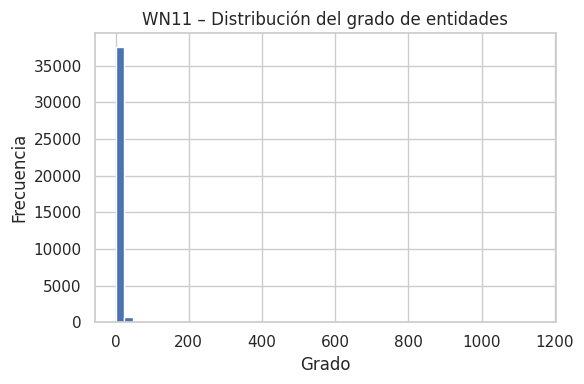

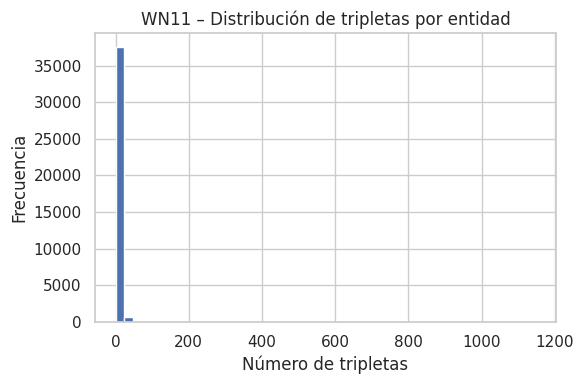

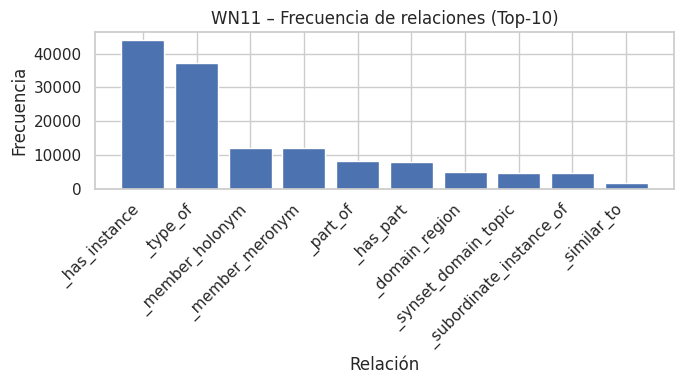

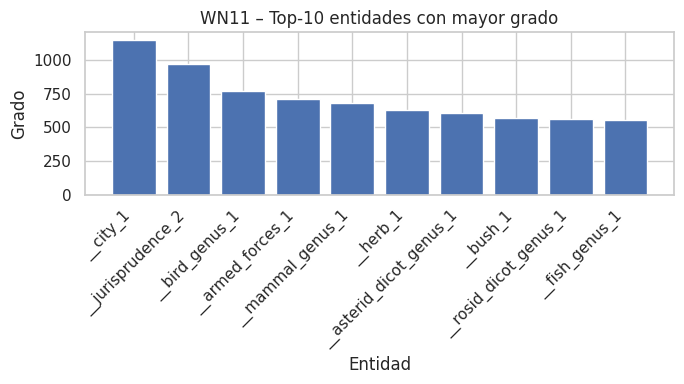

In [26]:
univariate_eda_kg(FINAL_DATA_DIR, dataset_name="WN11", top_n=10)

# Análisis bi/multivariante

El análisis bivariante y multivariante se plantea tradicionalmente para explorar relaciones de dependencia o correlación entre variables numéricas. Sin embargo, en el presente trabajo los datos corresponden a grafos de conocimiento representados mediante tripletas
(
ℎ
,
𝑟
,
𝑡
)
(h,r,t), donde las variables originales son de naturaleza categórica y no existen atributos numéricos continuos independientes.

Si bien es posible definir métricas estructurales derivadas del grafo (como el grado de las entidades o la frecuencia de las relaciones), estas métricas no constituyen variables independientes en el sentido estadístico, ya que están directamente determinadas por la estructura del propio grafo. En consecuencia, la aplicación de análisis de correlación clásicos (por ejemplo, coeficientes de Pearson o Spearman) no resulta metodológicamente apropiada ni aporta información adicional significativa.

Por esta razón, el análisis exploratorio se centra en la caracterización univariante de las principales métricas estructurales del grafo, dejando el estudio de interacciones más complejas para etapas posteriores relacionadas con el modelado y la evaluación del desempeño de los algoritmos de aprendizaje.


# Preprocesamiento

En el contexto de grafos de conocimiento representados mediante tripletas
(
ℎ
,
𝑟
,
𝑡
)
(h,r,t), las estrategias clásicas de preprocesamiento asociadas al manejo de valores faltantes, atípicos y reducción de cardinalidad no aplican de la misma manera que en conjuntos de datos tabulares. Las tripletas no contienen atributos numéricos continuos, por lo que no existen valores faltantes en el sentido tradicional, sino únicamente ausencia de conocimiento, la cual constituye parte fundamental del problema a resolver.

De forma similar, las entidades o relaciones con baja frecuencia de aparición no se consideran valores atípicos, sino elementos válidos que reflejan la naturaleza dispersa y de cola larga característica de los grafos de conocimiento reales. Su eliminación o modificación introduciría sesgos estructurales y afectaría negativamente la capacidad del modelo para generalizar a entidades o relaciones no vistas durante el entrenamiento.

Finalmente, aunque los conjuntos de datos presentan una alta cardinalidad en entidades y relaciones, esta característica no se aborda mediante técnicas de reducción en la etapa de preprocesamiento. En su lugar, se gestiona posteriormente a través de representaciones embebidas aprendidas por el modelo, preservando la riqueza estructural del grafo. Por estas razones, no se aplican transformaciones de preprocesamiento clásicas, manteniendo los datos en su forma original.

# Conclusiones

El análisis exploratorio permitió caracterizar la estructura fundamental de los grafos de conocimiento analizados a partir de métricas derivadas, dado que los datos originales se representan mediante tripletas categóricas. Las estadísticas globales y el análisis univariante evidencian una marcada heterogeneidad en la distribución de entidades y relaciones, así como la presencia de distribuciones de cola larga tanto en el grado de las entidades como en la frecuencia de las relaciones. Este comportamiento es consistente con grafos de conocimiento reales y pone de manifiesto la existencia de nodos altamente conectados junto con una gran cantidad de entidades poco frecuentes.

Asimismo, el EDA confirmó que la ausencia de ciertas tripletas y la baja frecuencia de algunas entidades o relaciones no constituyen anomalías, sino propiedades intrínsecas del problema de inferencia en grafos de conocimiento. En consecuencia, no se aplicaron estrategias clásicas de limpieza o reducción de datos, ya que estas podrían introducir sesgos y afectar la capacidad de generalización del modelo. Los resultados de esta etapa proporcionan una base sólida para el diseño y entrenamiento de modelos de aprendizaje capaces de manejar alta cardinalidad, dispersión estructural y escenarios de inferencia con información incompleta.